In [76]:
import cv2
import numpy as np
from ipywidgets import interactive
from matplotlib import pyplot as plt
import json

# 캘리브레이션 데이터 로드
with open("camera_calibration_data.json", "r") as f:
    calibration_data = json.load(f)

camera_matrices = [np.array(mtx) for mtx in calibration_data["camera_matrices"]]
dist_coeffs = [np.array(dist) for dist in calibration_data["dist_coeffs"]]
rot_vectors = [np.array(rvec) for rvec in calibration_data["rot_vectors"]]
trans_vectors = [np.array(tvec) for tvec in calibration_data["trans_vectors"]]
square_size = 4  # 4 cm

print(f"################ camera calibration #############")
print(f"camera_matrices: {camera_matrices}")
print(f"dist_coeff: {dist_coeffs}")
print(f"rot_vectors: {rot_vectors}")
print(f"trans_vectors: {trans_vectors}")
print(f"################ camera calibration #############")

# 각 카메라의 투영 행렬 계산
projection_matrices = []
for cam_idx, (K, rvec, tvec) in enumerate(zip(camera_matrices, rot_vectors, trans_vectors)):
    R, _ = cv2.Rodrigues(rvec)  # 회전 벡터를 회전 행렬로 변환
    T = tvec.reshape(3, 1)          # 변환 벡터
    RT = np.hstack((R, T))          # [R | T]
    P = np.dot(K, RT)               # 투영 행렬: K * [R | T]
    projection_matrices.append(P)

# Data pre-processing: 0 or None value is replaced by nearest value
def data_pre_processing(points_data):
    # Treat 0 as missing (convert 0 to np.nan)
    points_data[points_data == 0] = np.nan
    # print(points_data)
    # Forward fill
    for i in range(1, len(points_data)):
        mask = np.isnan(points_data[i, :])
        points_data[i, mask] = points_data[i - 1, mask]
    
    # Backward fill
    for i in range(len(points_data) - 2, -1, -1):
        mask = np.isnan(points_data[i, :])
        points_data[i, mask] = points_data[i + 1, mask]

    return points_data

def triangulate_points(row, conf, camera_cnt):
    points_2d = np.array(row).reshape(5, 2)  # (x, y) 좌표로 변환
    
    # 왜곡 보정된 좌표로 변환
    undistorted_points = []
    for cam_idx, (pt, K, dist) in enumerate(zip(points_2d, camera_matrices, dist_coeffs)):
        pts = np.array([pt], dtype=np.float32).reshape(-1, 1, 2)
        undistorted = cv2.undistortPoints(pts, K, dist, None, K).reshape(-1, 2)
        undistorted_points.append(undistorted[0])

    # conf 높은 순으로 index 정렬
    sorted_indices = sorted(range(len(conf)), key=lambda i: conf[i], reverse=True)
    
    # 최소 두 카메라를 선택하여 삼각화 수행: (0,0)이 아닌 카메라 2개 찾기
    cam_idx = []
    points = []
    cnt = 0
    for i in sorted_indices:
        if(conf[i] > 0.25):
            cam_idx.append(i)
            points.append(np.array(undistorted_points[i], dtype=np.float32).reshape(2, 1))
            cnt += 1

    if(cnt < 2):
        return [0.0, 0.0, 0.0]
    else:
        # Triangulation: 2D 좌표에서 3D 좌표 계산
        triangulated_point = cv2.triangulatePoints(
            projection_matrices[cam_idx[0]], projection_matrices[cam_idx[1]],
            points[0], points[1]
        )
    
        # 동차 좌표를 디카르트 좌표로 변환
        triangulated_point /= triangulated_point[3]

        # square_size 를 곱해서 실제 위치 계산
        triangulated_point = triangulated_point * square_size
        return triangulated_point[:3].flatten()

# Load points from file and process
# input_file = "D:/spkim/data/20241114_40Hz_test/20241114_40Hz_test/C_20Hz_Bandi_20fps.txt"  # File containing points
input_file = "border_test2.txt"
points_data = np.loadtxt(input_file, delimiter="\t")  # Load the data from file

# Extract 2D points and confidences
triangulated_points = []
keypoint_cnt = 9
camera_cnt = 5

x_min, y_min, z_min = 9999, 9999, 9999
x_max, y_max, z_max = -9999, -9999, -9999

for row in points_data:
    triangulated_row = []  # Store triangulated points for one row
    for i in range(keypoint_cnt):
        points_2d = []
        conf = []
        for j in range(camera_cnt):
            x, y, confidence = row[j*keypoint_cnt*3 + i*3 : j*keypoint_cnt*3 + i*3 + 3]
            points_2d.append(x)
            points_2d.append(y)
            conf.append(confidence)
        
        point_3d = triangulate_points(points_2d, conf, camera_cnt)

        # Get range of axis
        if(x_min > point_3d[0]): x_min = point_3d[0]
        if(x_max < point_3d[0]): x_max = point_3d[0]
        if(y_min > point_3d[1]): y_min = point_3d[1]
        if(y_max < point_3d[1]): y_max = point_3d[1]
        if(z_min > point_3d[2]): z_min = point_3d[2]
        if(z_max < point_3d[2]): z_max = point_3d[2]
        # print(f"{x_min} {x_max} {y_min} {y_max} {z_min} {z_max}")
        
        triangulated_row.extend(point_3d)
    
    triangulated_points.append(triangulated_row)

# Save triangulated points to a text file
# output_file = "triangulated_points.txt"
output_file = "border_test_result2.txt"
np.savetxt(output_file, triangulated_points, fmt="%.6f", comments="", delimiter="\t")

def plot_frame_with_slider(frame_idx):
    plt.clf()  # Clear the current figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    row = triangulated_points[frame_idx]
    colors = plt.cm.tab10(np.arange(len(row) // 3) % 10)  # Use tab10 colormap for distinct colors
    for i, color in zip(range(0, len(row), 3), colors):
        x, y, z = row[i], row[i + 1], row[i + 2]
        ax.scatter(x, y, z, c=[color], marker='o')
    
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title(f"3D Points - Frame {frame_idx + 1}")
    
    # x, y, z 축 범위 설정
    ax.set_xlim(x_min, x_max)  # x축 범위
    ax.set_ylim(y_min, y_max)  # y축 범위
    ax.set_zlim(z_min, z_max)  # z축 범위

    # ax.set_xlim(-10, 6)  # x축 범위
    # ax.set_ylim(5, 20)  # y축 범위
    # ax.set_zlim(-16, 0)  # z축 범위
    
    plt.show()

# Create an interactive slider
interactive_plot = interactive(plot_frame_with_slider, frame_idx=(0, len(triangulated_points) - 1))
display(interactive_plot)

################ camera calibration #############
camera_matrices: [array([[1.06564641e+03, 0.00000000e+00, 5.94924440e+02],
       [0.00000000e+00, 1.06969721e+03, 1.03209179e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), array([[1.07011857e+03, 0.00000000e+00, 6.06849467e+02],
       [0.00000000e+00, 1.07790904e+03, 1.03963310e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), array([[1.07292399e+03, 0.00000000e+00, 5.62253619e+02],
       [0.00000000e+00, 1.07238707e+03, 6.76445224e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), array([[1.05351483e+03, 0.00000000e+00, 6.45557261e+02],
       [0.00000000e+00, 1.06877249e+03, 1.03721384e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), array([[1.04101463e+03, 0.00000000e+00, 6.05379366e+02],
       [0.00000000e+00, 1.04895329e+03, 9.06351964e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])]
dist_coeff: [array([-0.07435691,  0.08911365,  0.0144337 , -0.00183

interactive(children=(IntSlider(value=39, description='frame_idx', max=79), Output()), _dom_classes=('widget-i…

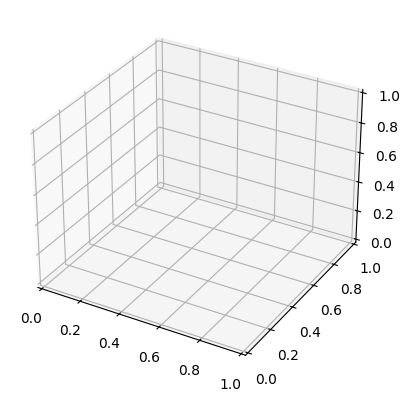

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# 샘플 데이터 생성 함수
def generate_data(num_frames):
    """임의의 (x, y, z) 좌표 9개를 프레임 수 만큼 생성"""
    data = []
    for _ in range(num_frames):
        frame = np.random.rand(9, 3) * 10  # 좌표 범위를 (0,10)으로 설정
        data.append(frame)
    return data

# 애니메이션 업데이트 함수
def update(frame):
    ax.clear()
    ax.set_xlim(-10, 6)  # x축 범위
    ax.set_ylim(5, 20)  # y축 범위
    ax.set_zlim(-16, 0)  # z축 범위
    ax.set_title(f'Frame {frame+1}')
    
    # 현재 프레임의 점 그리기
    row = triangulated_points[frame]
    colors = plt.cm.tab10(np.arange(len(row) // 3) % 10)  # Use tab10 colormap for distinct colors
    for i, color in zip(range(0, len(row), 3), colors):
        x, y, z = row[i], row[i + 1], row[i + 2]
        ax.scatter(x, y, z, c=[color], marker='o')

# 애니메이션 설정
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

num_frames = 200  # 프레임 수
# data = triangulated_points
data  = triangulated_points

# 애니메이션 객체를 명확하게 변수에 저장
anim = FuncAnimation(fig, update, frames=num_frames, interval=50, repeat=True)

# 애니메이션 객체를 메모리에 유지
plt.show()

anim.save('animation.mp4', writer='ffmpeg')

<Figure size 640x480 with 0 Axes>

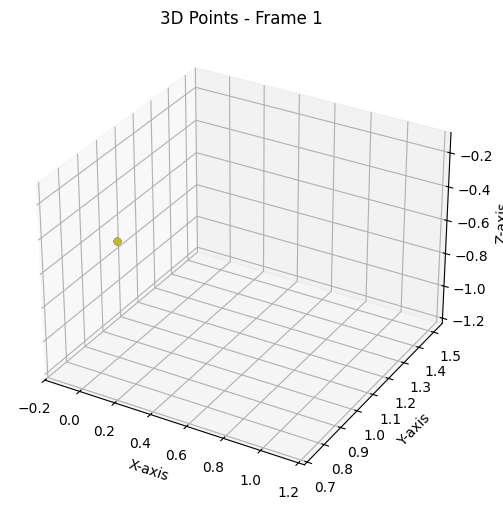

<Figure size 640x480 with 0 Axes>

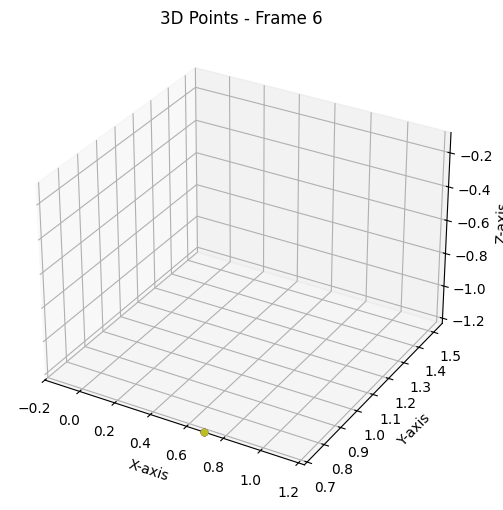

<Figure size 640x480 with 0 Axes>

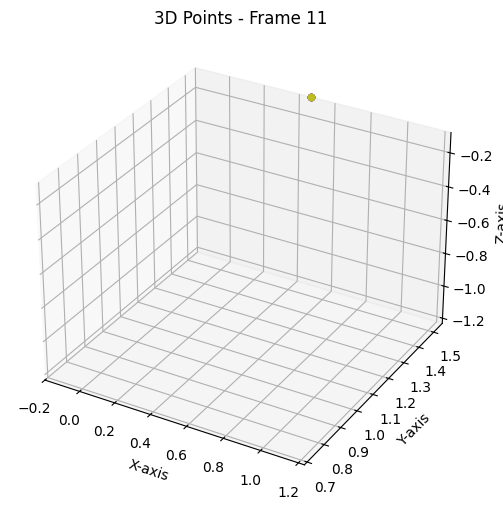

<Figure size 640x480 with 0 Axes>

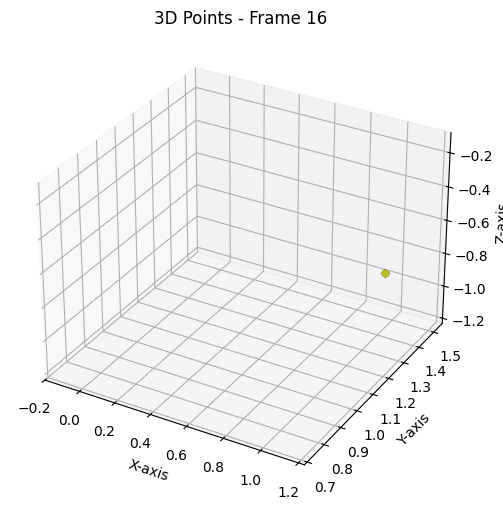

In [77]:
plot_frame_with_slider(0)
plot_frame_with_slider(5)
plot_frame_with_slider(10)
plot_frame_with_slider(15)